# Predict with future weather

In [2]:
from toolbox import *

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import pickle

In [3]:
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [4]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, SelectFromModel

from sklearn.model_selection import GridSearchCV

In [5]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

## Load data

In [6]:
#ws = load_weather_station_data('./data/weather_station_list.csv')
w = load_weather_data('./data/weather_future/scenario_ref.csv')
w = calc_cumulative_weather(w)

gs = load_groundwater_station_data('./data/groundwater/bergstraße/gw_stations_bergstraße.csv')
g = load_groundwater_data('./data/groundwater/bergstraße/gw.csv')

gs_agg = calc_aggregate_station_data(gs, g)
# setting more years improves model predictions
gs_agg = calc_initial_station_data(gs_agg, g, initial_n_years=5) 


### Create regional clusters from gw stations

A good number of clusters is 10-12. Re-run if station data is changed.

In [7]:
#explore_clusters(gs_agg[['x', 'y']])

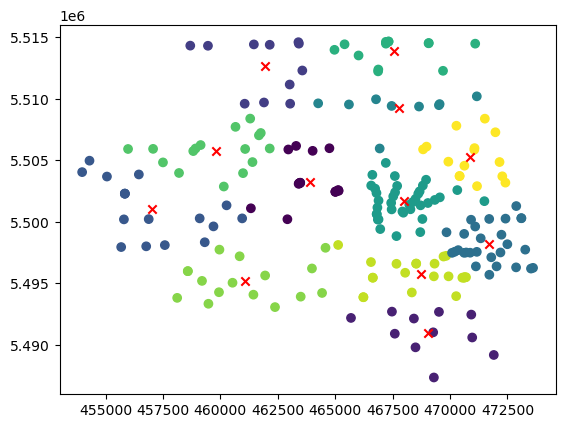

In [8]:
labels, centers = apply_clusters(gs_agg[['x', 'y']], 12, scale=False)

plot_clusters(gs_agg[['x', 'y']], labels, centers)

# Add clusters to stations
gs_agg['reg_clusters'] = labels
#gs_agg['reg_clusters'] = 0

### Merge data

In [9]:
g_merged = merge_groundwater_data(g, gs_agg)
#g_merged.describe()

In [10]:
#g_merged.head()

In [12]:
m = pd.merge(g_merged, w,
             how='left', left_index=True, right_index=True)

In [13]:
m.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 557260 entries, 1912-10-15 to 2024-03-20
Data columns (total 41 columns):
 #   Column                      Non-Null Count   Dtype          
---  ------                      --------------   -----          
 0   station_id                  557260 non-null  int64          
 1   date                        557260 non-null  datetime64[ns] 
 2   water_dist                  554273 non-null  float64        
 3   water_level                 554273 non-null  float64        
 4   water_depth                 554273 non-null  float64        
 5   water_temp                  66890 non-null   float64        
 6   x                           557260 non-null  float64        
 7   y                           557260 non-null  float64        
 8   start_date                  557260 non-null  datetime64[ns] 
 9   end_date                    557260 non-null  datetime64[ns] 
 10  ground_elev                 557260 non-null  float64        
 11  measure_el

In [14]:
m.describe()

,station_id,date,water_dist,water_level,water_depth,water_temp,x,y,start_date,end_date,...,precip_mean_prev_7d_sum,tmean_mean_prev_7d_mean,precip_mean_prev_30d_sum,tmean_mean_prev_30d_mean,precip_mean_prev_90d_sum,tmean_mean_prev_90d_mean,precip_mean_prev_1y_sum,tmean_mean_prev_1y_mean,precip_mean_prev_3y_sum,tmean_mean_prev_3y_mean
count,557260.000000,557260,554273.000000,554273.000000,554273.000000,66890.00000,557260.000000,5.572600e+05,557260,557260,...,261778.000000,261778.000000,261319.000000,261319.000000,259943.000000,259943.000000,253937.000000,253937.000000,237770.000000,237770.000000
mean,13589.102144,1995-03-01 05:35:27.078921856,3.594004,89.469690,3.220631,12.27388,465759.276823,5.501905e+06,1966-12-22 22:03:30.291784816,2017-11-11 00:57:30.511431168,...,13.553365,10.094269,58.092607,10.104721,174.390739,10.135471,706.887209,10.103328,2118.915731,10.101306
min,12890.000000,1912-10-15 00:00:00,0.000000,81.140000,-0.870000,2.02000,453983.000000,5.487354e+06,1912-01-01 00:00:00,1966-01-01 00:00:00,...,3.179936,0.232753,33.786290,1.179873,136.134168,2.017988,668.570977,10.017296,2057.468638,10.071740
25%,13157.000000,1980-08-25 00:00:00,2.500000,86.900000,2.100000,11.30000,461900.003000,5.497120e+06,1953-01-01 00:00:00,2024-03-01 00:00:00,...,10.899160,3.296927,51.265472,3.526549,161.107638,4.368666,697.380704,10.086928,2105.620456,10.090351
50%,13568.000000,1997-12-01 00:00:00,3.360000,89.240000,3.030000,12.00000,466857.965000,5.501588e+06,1973-01-01 00:00:00,2024-03-01 00:00:00,...,13.076597,9.207563,57.330948,9.624721,174.569748,9.990525,707.334770,10.104048,2117.647835,10.101510
75%,13774.000000,2013-08-22 00:00:00,4.400000,92.090000,4.040000,12.90000,469927.000000,5.505957e+06,1978-01-01 00:00:00,2024-03-01 00:00:00,...,15.778340,16.305345,64.509759,16.150012,186.347288,15.939850,715.736084,10.122640,2130.475141,10.108813
max,17794.000000,2024-03-20 00:00:00,11.160000,96.270000,10.790000,21.30000,473615.000000,5.514651e+06,2013-01-01 00:00:00,2024-03-01 00:00:00,...,31.068251,20.618877,94.414325,19.859505,226.707239,18.575481,747.384501,10.175205,2177.794176,10.139199
std,609.112889,NaN,1.527469,3.005891,1.476485,1.55057,4829.443303,6.203696e+03,NaN,NaN,...,3.776524,6.436346,9.090525,6.353987,17.470859,5.784471,13.453420,0.026492,21.256684,0.014132
